# Temat 2
Martyna Duda (Dziurdziak)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import model_selection,  metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from collections import Counter
from xgboost.sklearn import XGBClassifier

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

import warnings
warnings.filterwarnings("ignore")

## Analiza i przygotowanie danych

**Wczytanie zbioru**

In [2]:
with open("Train.csv","rb") as f:
    text = f.readlines()
f.close()
print(text[:2])

[b'ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed\r\n', b'ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000,5,0,CYBOSOL,HDFC Bank,N,0,HBXX,,,,,,N,Web-browser,G,S122,1,0,0\r\n']


In [3]:
data = pd.read_csv("Train.csv", encoding="ISO-8859-1")
data.shape

(87020, 26)

**Rozkład zmiennej objaśnianej**
* Mamy doczynienia z problemem niezbalansowanych klas

Średnia ze zmiennej objaśnianej = 0.01462882096069869, Suma po zmiennej objaśnianej = 1273


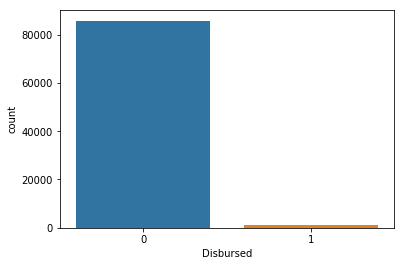

In [4]:
sns.countplot(x='Disbursed',data=data)
print('Średnia ze zmiennej objaśnianej = {}, Suma po zmiennej objaśnianej = {}'.format(data.Disbursed.mean(), data.Disbursed.sum()))

**Podział na zbioru na dwa: zmienną objaśnianą i zmienne objaśniające**

In [5]:
y = data.Disbursed
X = data.drop(["Disbursed"],axis=1)

**Podział danych na zbiór treningowy i testowy**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify = y)

**Pierwsza weryfikacja zmiennych - usunięcie zmiennych nieprzydatnych do modelowania**
* LoggedIn - zgodnie z poleceniem w zadaniu
* ID - sztuczny identyfikator, należy go usunąć bo zaburzy wyniki, nie niesie ze sobą żadnej informacji
* Employer_Name - nazwa pracodawcy - ma bardzo dużo wartości, poza tym sugerowanie się konkretną nazwą firmy nie jest właściwe, można próbować na podstawie nazwy klasyfikować firmy np. Wojsko, IT,.. itp. na potrzeby mojego modelu, odrzucam tą zmienną.

In [7]:
X_train = X_train.drop(columns=["LoggedIn","ID","Employer_Name"])
X_test = X_test.drop(columns=["LoggedIn","ID","Employer_Name"])

In [8]:
X_train.head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,...,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
18418,Female,Bengaluru,17000,10-Apr-91,21-May-15,0.0,0.0,0.0,ICICI Bank,N,...,NaN,NaN,NaN,NaN,NaN,N,Mobile,C,S144,1
44924,Female,Kolkata,12500,02-Feb-81,21-Jun-15,15000.0,1.0,1180.0,Federal Bank,N,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S159,1
58622,Male,Delhi,22000,05-Jul-91,04-Jul-15,100000.0,1.0,1650.0,NaN,Y,...,100000.0,1.0,28.50,2000.0,9675.08,Y,Web-browser,G,S122,5
55873,Female,Delhi,46000,22-Jan-88,02-Jul-15,0.0,0.0,0.0,ICICI Bank,Y,...,780000.0,4.0,15.25,15600.0,21806.96,Y,Mobile,G,S122,5
65364,Male,Hyderabad,50000,02-Apr-80,12-Jul-15,400000.0,4.0,4000.0,HDFC Bank,Y,...,400000.0,4.0,15.25,8000.0,11183.06,N,Web-browser,G,S122,4


**Analiza typów zmiennych**

In [9]:
X_train.dtypes

Gender                    object
City                      object
Monthly_Income             int64
DOB                       object
Lead_Creation_Date        object
Loan_Amount_Applied      float64
Loan_Tenure_Applied      float64
Existing_EMI             float64
Salary_Account            object
Mobile_Verified           object
Var5                       int64
Var1                      object
Loan_Amount_Submitted    float64
Loan_Tenure_Submitted    float64
Interest_Rate            float64
Processing_Fee           float64
EMI_Loan_Submitted       float64
Filled_Form               object
Device_Type               object
Var2                      object
Source                    object
Var4                       int64
dtype: object

**Dodanie nowej zmiennej Customer_Age wyznaczonej na podstawie zmiennych DOB i Lead_Creation_Date**
* DOB i Lead_Creation_Date są zmiennymi typu object, mimo że przechowują daty urodzenia i złożenia wniosku (datetime)
* Lead_Creation_Date - mamy wnioski tylko z trzech miesięcy. Jest to za krótki przedział czasu, zeby wykorzystać tą zmienną w modelowaniu.
* Na podstawie zmiennych DOB i Lead_Creation_Date zostanie wyznaczony wiek klienta w momencie wnioskowania o kredyt, a zmienne DOB i Lead_Creation_Date zostaną usunięte

In [10]:
# zamiana DOB i Lead_Creation_Date na typdatetime
X_train["DOB"] = pd.to_datetime(X_train["DOB"],format='%d-%b-%y')
X_train['DOB'] = X_train['DOB'].mask(X_train['DOB'].dt.year > 2015, 
                                         X_train['DOB'] - pd.offsets.DateOffset(years=100))
X_train["Lead_Creation_Date"] = pd.to_datetime(X_train["Lead_Creation_Date"])

X_test["DOB"] = pd.to_datetime(X_test["DOB"],format='%d-%b-%y')
X_test['DOB'] = X_test['DOB'].mask(X_test['DOB'].dt.year > 2015, 
                                         X_test['DOB'] - pd.offsets.DateOffset(years=100))
X_test["Lead_Creation_Date"] = pd.to_datetime(X_test["Lead_Creation_Date"])

# wyznaczenie wieku
X_train['Customer_Age'] = (X_train.Lead_Creation_Date - X_train.DOB).astype('<m8[Y]') 
X_test['Customer_Age'] = (X_test.Lead_Creation_Date - X_test.DOB).astype('<m8[Y]') 

# usunięcie zbędnych zmiennych
X_train = X_train.drop(columns=["DOB","Lead_Creation_Date"])
X_test = X_test.drop(columns=["DOB","Lead_Creation_Date"])

In [11]:
# jest 11 rekordów (liczba zależna od podziału na zbiór testowy i treningowy) dla których osoba podała niepoprawnie DOB (Customer_Age=0)
X_train.loc[X_train["Customer_Age"]<17,:]

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,...,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Customer_Age
74092,Male,Noida,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
74101,Male,Mumbai,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
74093,Male,Delhi,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
74096,Male,Mumbai,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
60496,Male,Ahmedabad,8333,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
64278,Male,Bengaluru,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
70130,Female,NaN,24000,100000.0,0.0,8.0,NaN,N,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,7,0.0
74094,Male,Delhi,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
74097,Male,Bengaluru,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0
60141,Male,Hyderabad,0,0.0,0.0,0.0,NaN,Y,0,HBXX,...,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,0,0.0


**Dodatkowa zmienna Debt_to_Income**
* DTI określa jaka maksymalnie część miesięcznych dochodów kredytobiorcy (pożyczkobiorcy) może zostać przeznaczona przez niego na spłatę kredytu (pożyczki).
* Zmienną wyznaczam na podstawie zmiennych Existing_EMI, EMI_Loan_Submitted i Monthly_Income

In [12]:
X_train['Debt_to_Income']=(X_train['Existing_EMI']+X_train['EMI_Loan_Submitted'])/X_train['Monthly_Income']
X_test['Debt_to_Income']=(X_test['Existing_EMI']+X_test['EMI_Loan_Submitted'])/X_test['Monthly_Income']

### Analiza braków danych

**Sprawdzenie braków danych - wartości NaN**

In [13]:
#Wylistowanie kolumn zawierających braki danych
null_columns=X_train.columns[X_train.isnull().any()]

total = X_train[null_columns].isnull().sum().sort_values(ascending=False)
percent = (X_train[null_columns].isnull().sum()/X_train.shape[0]).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Processing_Fee,41761,0.685573
Debt_to_Income,41570,0.682438
EMI_Loan_Submitted,41546,0.682044
Interest_Rate,41546,0.682044
Loan_Tenure_Submitted,24319,0.399235
Loan_Amount_Submitted,24319,0.399235
Salary_Account,8252,0.135470
City,691,0.011344
Existing_EMI,52,0.000854
Loan_Tenure_Applied,52,0.000854


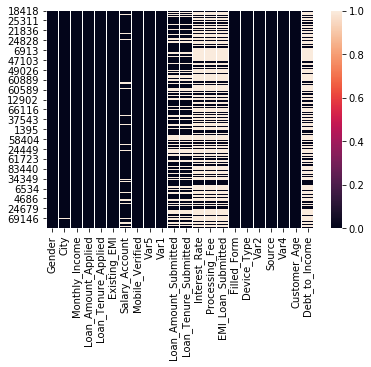

In [14]:
#Braki danych oznaczone na biało
sns.heatmap(X_train.isnull())

,Total,Percent
Processing_Fee,41761,0.685573
Debt_to_Income,41570,0.682438
EMI_Loan_Submitted,41546,0.682044
Interest_Rate,41546,0.682044
Loan_Tenure_Submitted,24319,0.399235


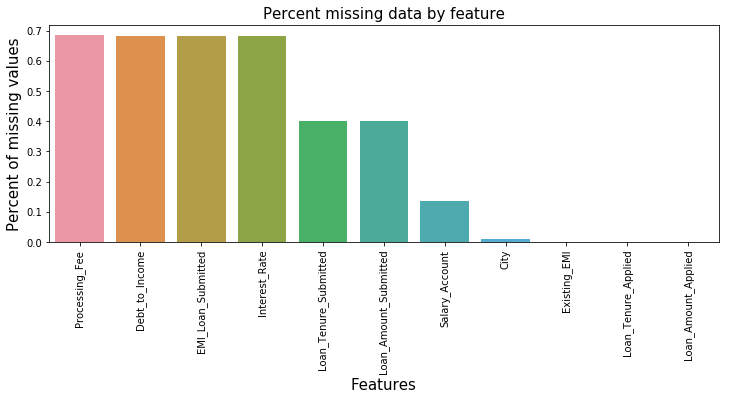

In [15]:
# Wykres dla kolumn z brakami danych
f, ax = plt.subplots(figsize=(12, 4))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

**Wnioski**

Braki danych występują w zmiennych:
* Processing_Fee - opłata manipulacyjna
* Debt_To_Income - DTI
* EMI_Loan_Submitted - miesięczna rata stała
* Interest_Rate 
* Loan_Tenure_Submitted 
* Loan_Amount_Submitted 
* Salary_Account 
* City 
* Existing_EMI 
* Loan_Tenure_Applied 
* Loan_Amount_Applied 

Braki danych w zmiennych numerycznych zostaną zastąpione 0, ponieważ występują, głównie dla wniosków zakończonych nieudzieleniem kredytu. Dla odrzuconych wniosków trudno mówić o przyznanych kwotach, opłatach, okresach czy racie. Nie wiadomo tez czy część z tych wniosków nie została anulowana przez sytem lub użytkownika na etapie wypełniania wniosku. 
Zauważyłam również, że mamy w danych przypadki gdy kwoty wnioskowane są missingami/zerami a kwoty przyznane   są większe od zera. Nie korygowałam tej sytuacji.

Braki danych w zmiennych kategorycznych zostaną zastąpione przez kategorię "Missing". Podobnie jak dla zmiennych kategorycznych braki danych występują głównie dla wniosków odrzuconych.

**Zastąpienie braków danych**
* Braki danych w zmiennych numerycznych zostaną zastąpione 0.

In [16]:
# lista kolumn numerycznych
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# zastąpienie braków zerami
X_train[num_cols] = X_train[num_cols].fillna(0)
X_test[num_cols] = X_test[num_cols].fillna(0)

* Braki danych w zmiennych kategorycznych zostaną zastąpione kategorią 'Missing'.

In [17]:
# lista kolumn kategorycznych
categ_cols = X_train.select_dtypes(include=[np.object]).columns.tolist()

# zastąpienie braków wartością 'Missing'
X_train[categ_cols]=X_train[categ_cols].fillna("Missing")
X_test[categ_cols]=X_test[categ_cols].fillna("Missing")

### Analiza zmiennych numerycznych

**Statystyki dla zmiennych numerycznych**

In [18]:
pd.options.display.float_format = "{:.2f}".format
X_train[num_cols].describe()

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,Customer_Age,Debt_to_Income
count,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00,60914.00
mean,59847.26,229408.54,2.13,3796.39,4.94,237010.21,2.34,6.10,1617.08,3487.34,2.94,30.37,0.13
std,2488729.64,353580.36,2.01,47182.96,5.67,307508.10,2.11,9.51,3566.14,6624.40,1.70,7.10,0.21
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,16500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,26.00,0.00
50%,25000.00,100000.00,2.00,0.00,2.00,140000.00,3.00,0.00,0.00,0.00,3.00,29.00,0.00
75%,40000.00,300000.00,4.00,3500.00,11.00,360000.00,4.00,14.85,2000.00,5616.97,5.00,33.00,0.28
max,444554443.00,9999999.00,10.00,10000000.00,18.00,3000000.00,6.00,37.00,50000.00,144748.28,7.00,86.00,1.51


**Wykresy dla zmiennych numerycznych**

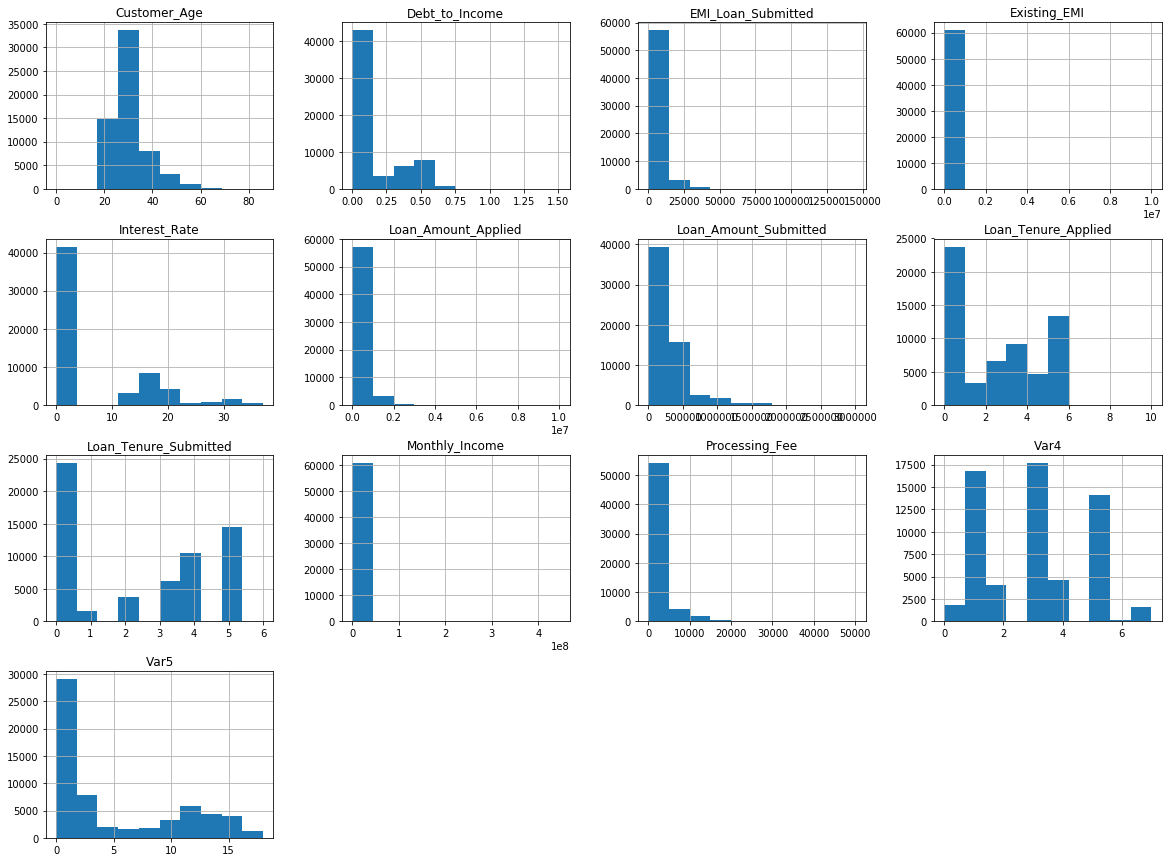

In [19]:
# Histogramy
plt.rcParams['figure.figsize'] = (20, 15)
X_train[num_cols].hist()
plt.rcParams['figure.figsize'] = (12, 6)

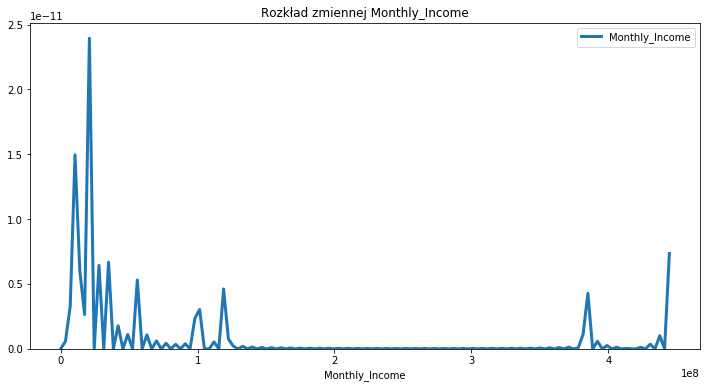

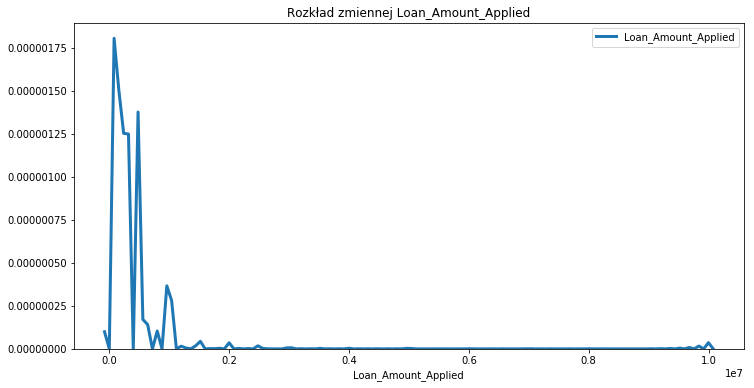

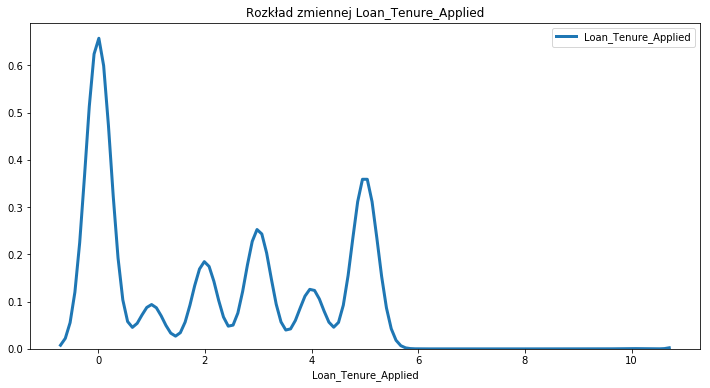

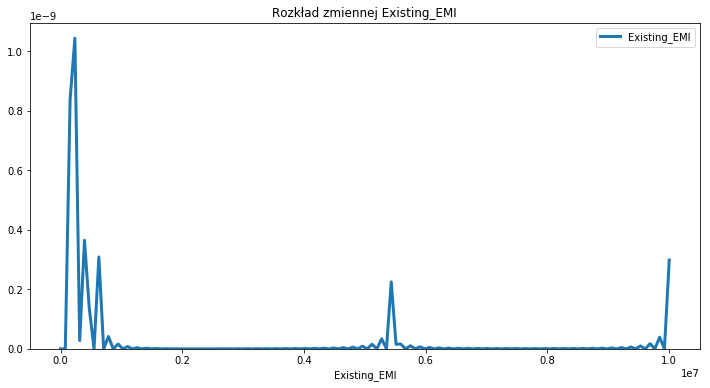

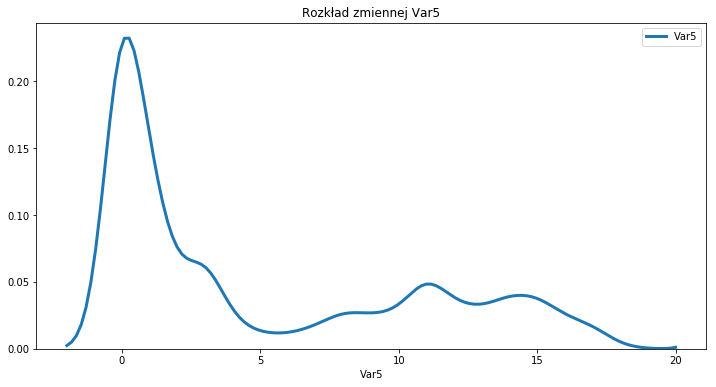

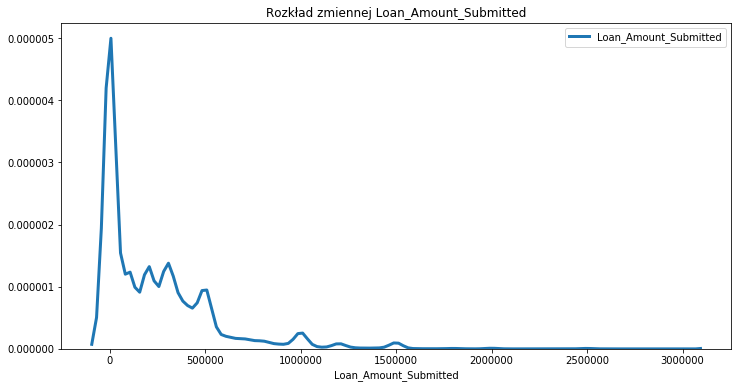

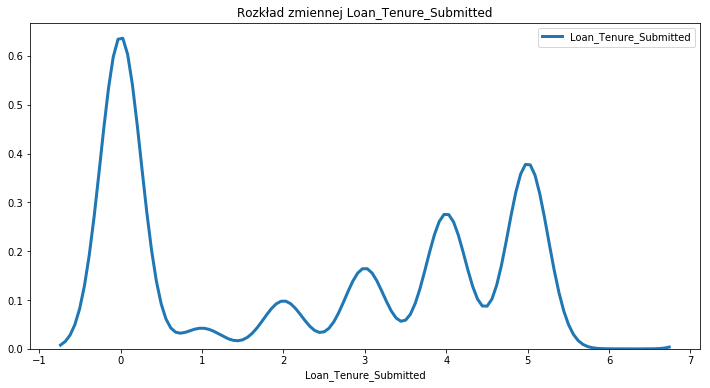

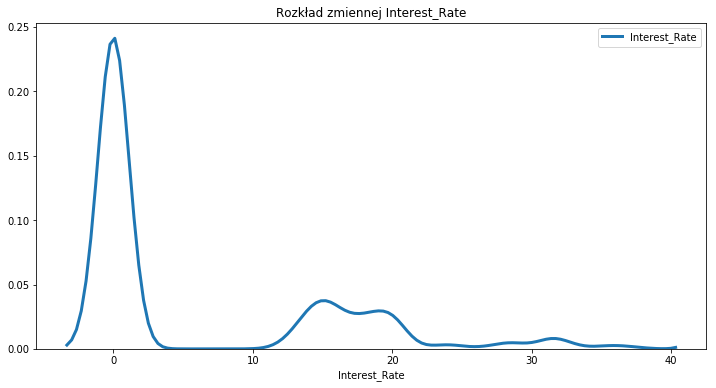

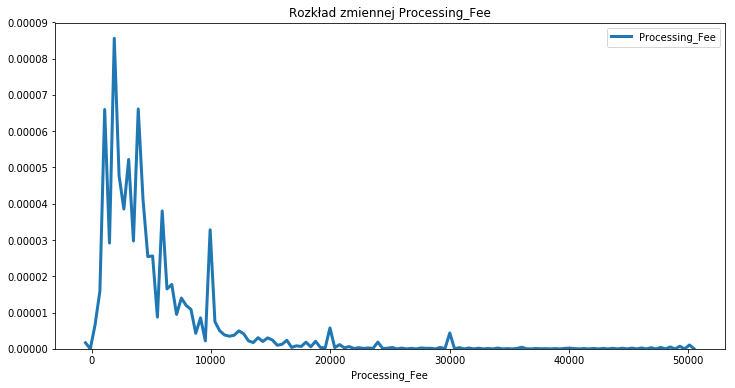

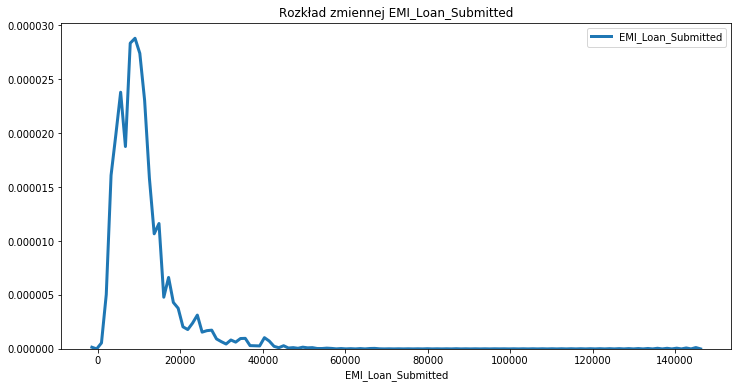

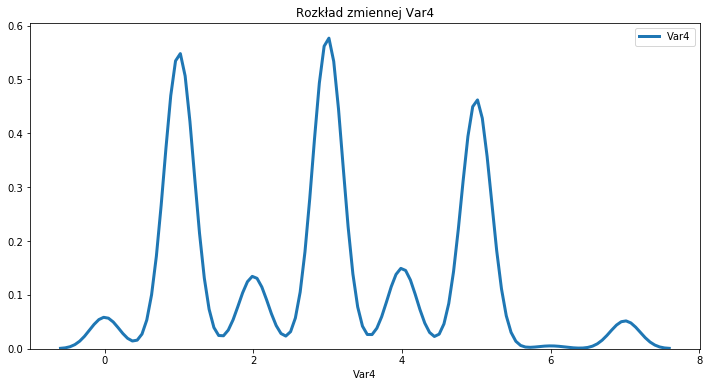

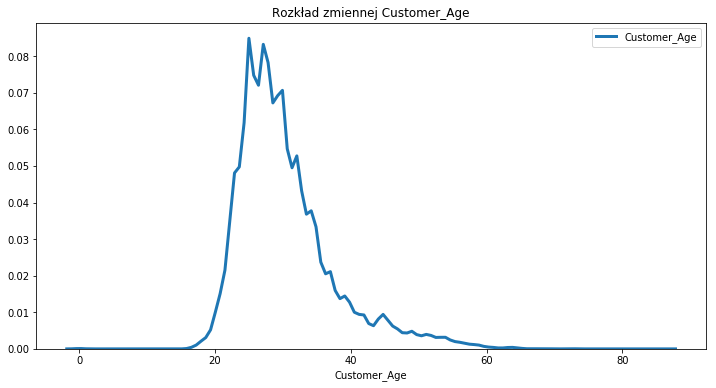

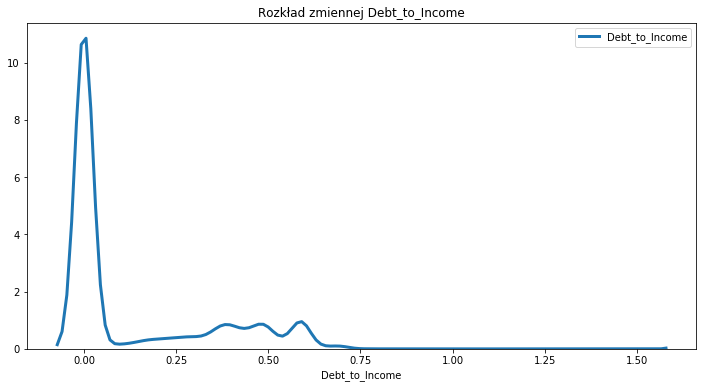

In [20]:
#Wykresy gęstości
def Density(data,columns):
    for column in columns:
        sns.distplot(data[column], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},label = column)
        plt.title('Rozkład zmiennej '+ column)
        plt.show()

Density(X_train[num_cols],num_cols)

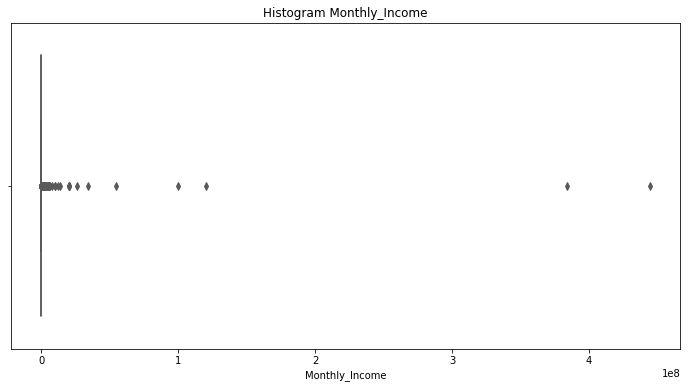

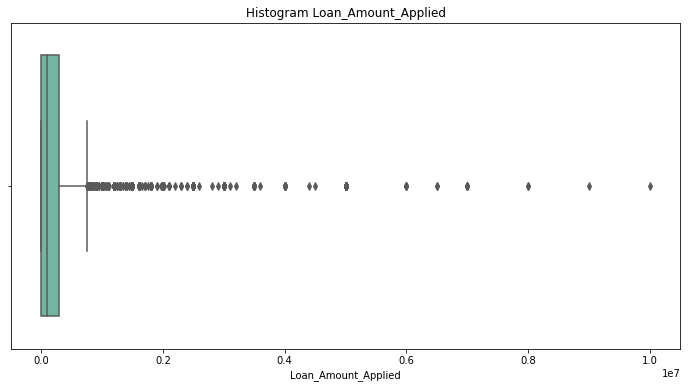

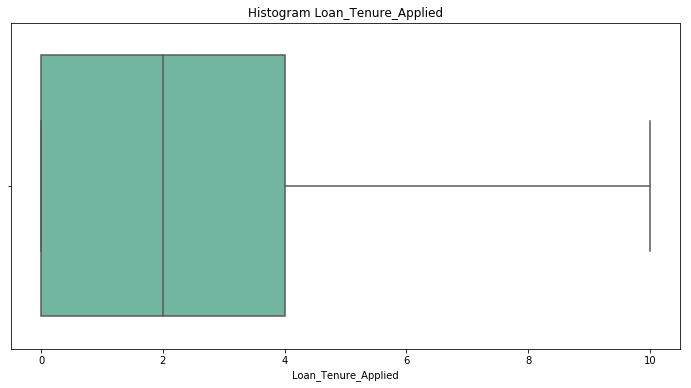

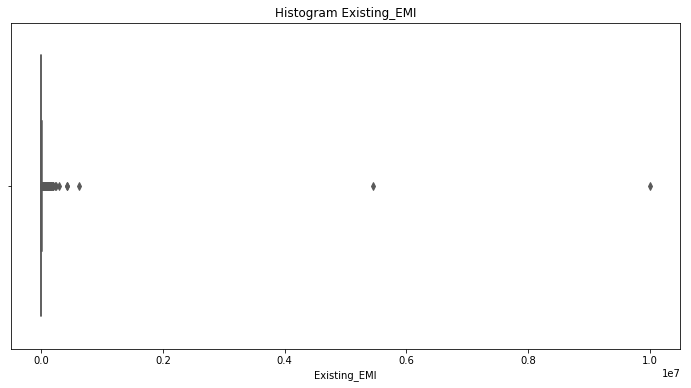

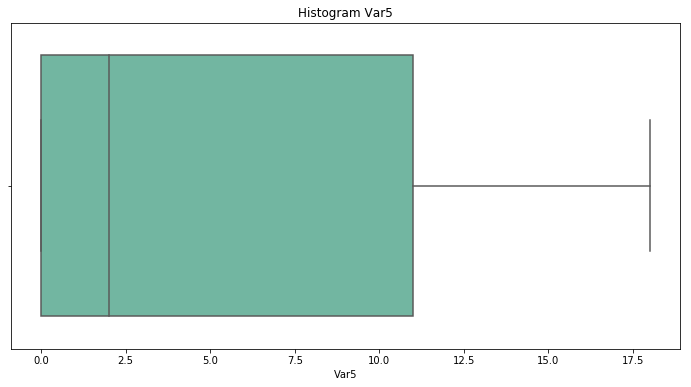

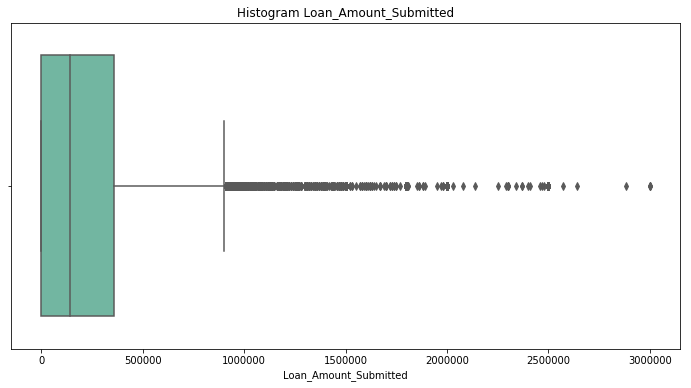

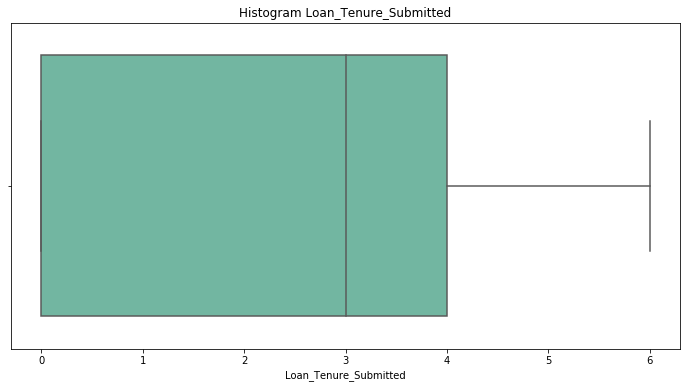

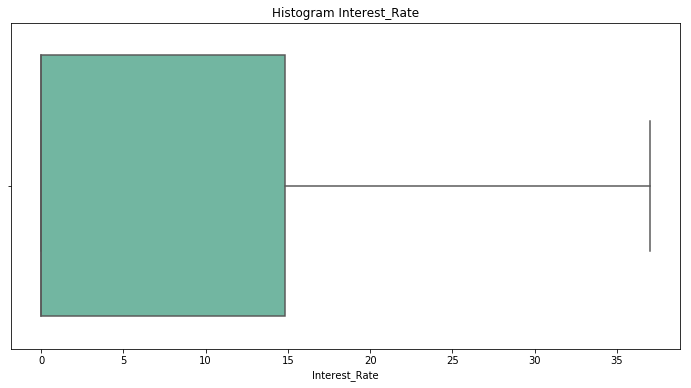

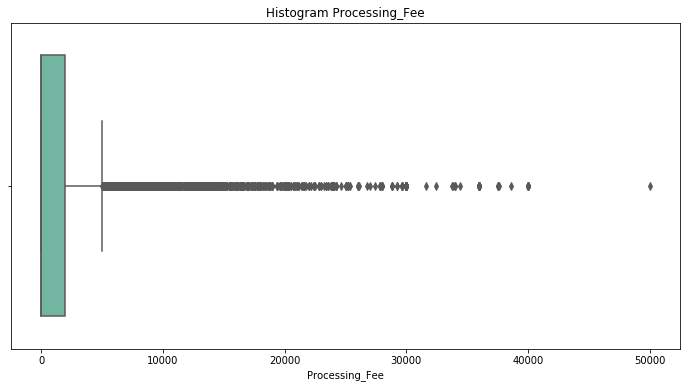

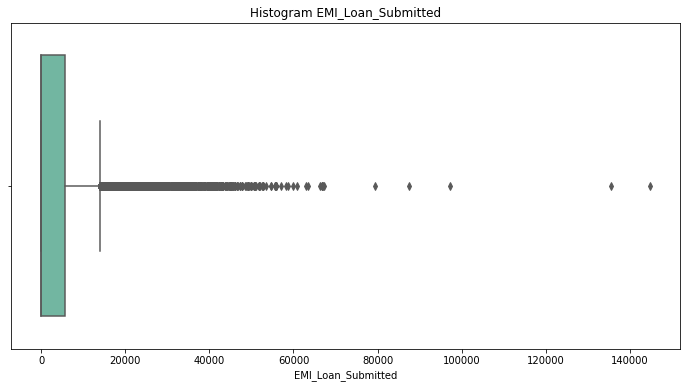

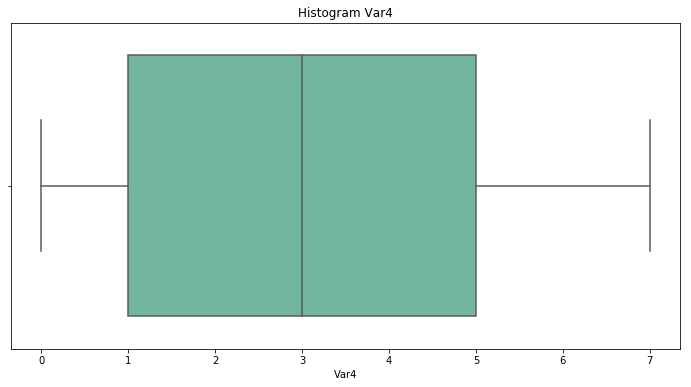

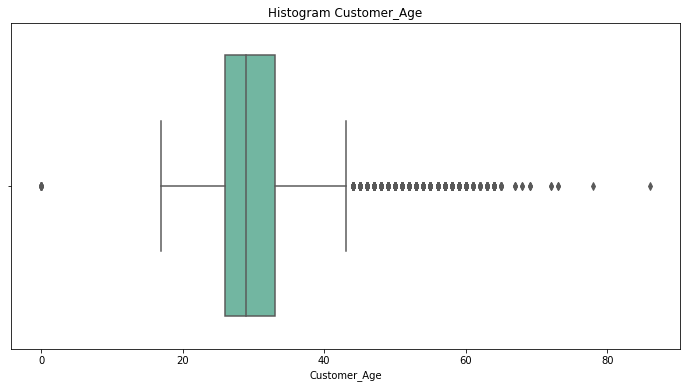

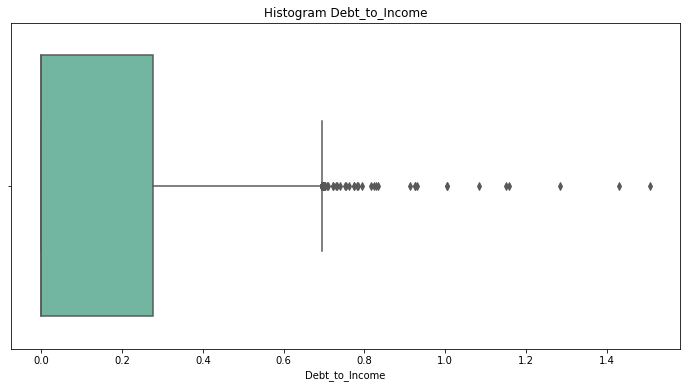

In [21]:
#Wykresy pudelkowe
def BoxPlot(data,columns):
    for column in columns:
        sns.boxplot(x=data[column],orient="h", palette="Set2",)
        plt.title('Histogram '+ column)
        plt.show()

BoxPlot(X_train,num_cols)

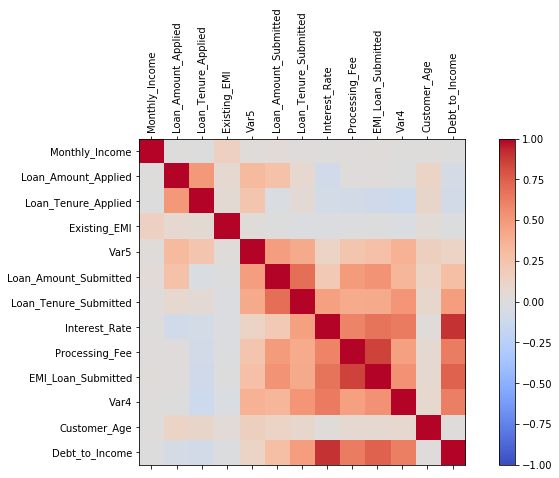

In [22]:
#Wykres korelacji
corr = X_train[num_cols].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train[num_cols].columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X_train[num_cols].columns)
ax.set_yticklabels(X_train[num_cols].columns)
plt.show()

**Wnioski**
* W danych mamy dużo zmiennych skorelowanych dodatnio (wraz ze wzrostem wartości jednej cechy, wzrasta wartość drugiej). Jest to wynik spodziewany, ponieważ np. wraz ze wzrostem kwoty wnioskowanej, wzrasta rata kredytu.
* Mamy też nieznaczną korelację ujemną np. wraz ze wzrostem okresu kredytowania spada wysokość raty.
* Mimo wykrycia korelacji zdecydowała się nie usuwać z tego powodu obserwacji z modelowania. 

### Analiza zmiennych kategorycznych

In [23]:
# lista kolumn tekstowych
categ_cols = X_train.select_dtypes(include=[np.object]).columns.tolist()
X_train[categ_cols].head()

,Gender,City,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
18418,Female,Bengaluru,ICICI Bank,N,HBXX,N,Mobile,C,S144
44924,Female,Kolkata,Federal Bank,N,HBXX,N,Web-browser,B,S159
58622,Male,Delhi,Missing,Y,HBXB,Y,Web-browser,G,S122
55873,Female,Delhi,ICICI Bank,Y,HAXC,Y,Mobile,G,S122
65364,Male,Hyderabad,HDFC Bank,Y,HAXC,N,Web-browser,G,S122


**Wykresy dla zmiennych kategorycznych**

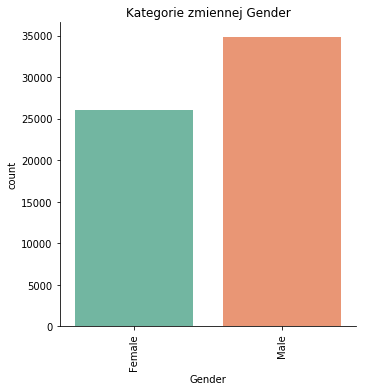

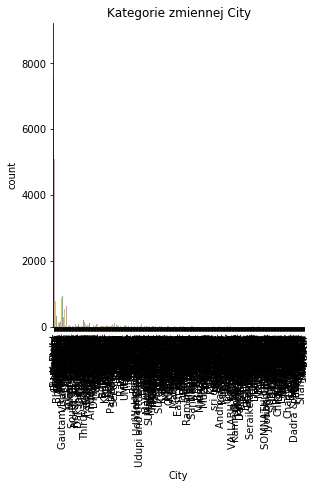

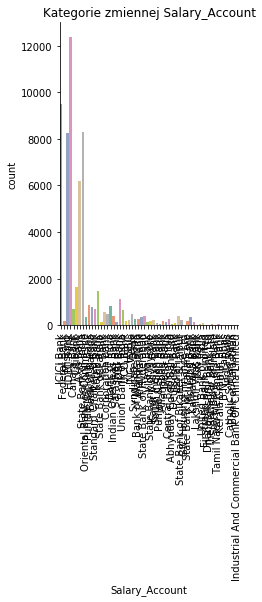

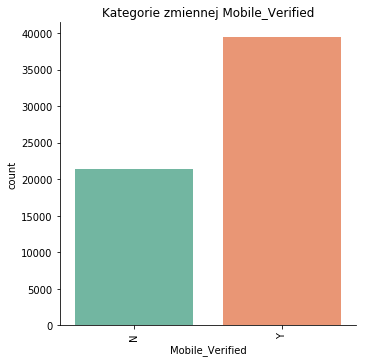

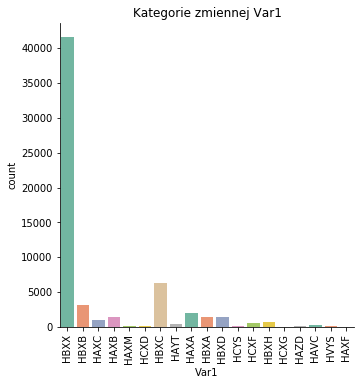

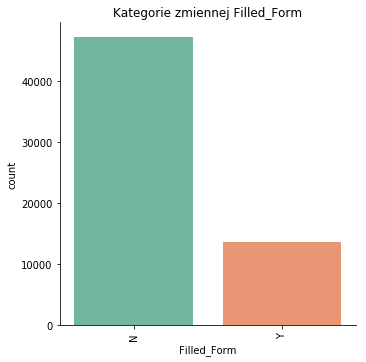

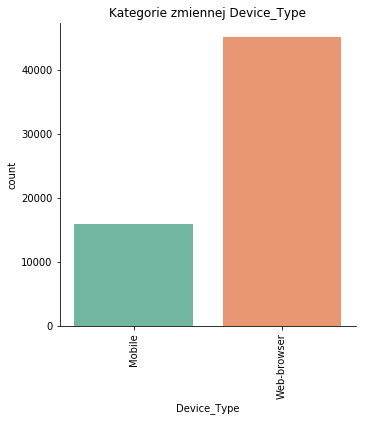

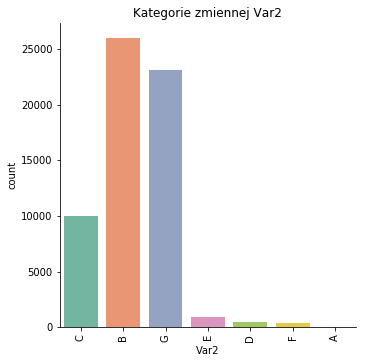

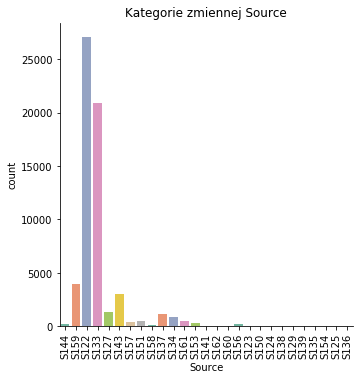

In [24]:
#Wykresy liczności klas
def CatPlot(data,columns):
    for column in columns:
        s = sns.catplot(x=column, kind="count", palette="Set2", data=data)
        s.set_xticklabels(rotation=90)
        plt.title('Kategorie zmiennej '+ column)
        plt.show()

CatPlot(X_train,categ_cols)

In [25]:
data.groupby('City')['ID'].count().sort_values(ascending=False)

City
Delhi                  12527
Bengaluru              10824
Mumbai                 10795
Hyderabad               7272
Chennai                 6916
Pune                    5207
Kolkata                 2888
Ahmedabad               1788
Jaipur                  1331
Gurgaon                 1212
Coimbatore              1147
Thane                    905
Chandigarh               870
Surat                    802
Visakhapatnam            764
Indore                   734
Vadodara                 624
Nagpur                   594
Lucknow                  580
Ghaziabad                560
Bhopal                   513
Kochi                    492
Patna                    461
Faridabad                447
Madurai                  375
Noida                    373
Gautam Buddha Nagar      338
Dehradun                 314
Raipur                   289
Bhubaneswar              277
                       ...  
Dantewada                  1
Damoh                      1
Poonch                     1
Nabha    

**Podejście do zmiennych tekstowych City, Salary_Account, Var1, Var2, Source**
* Dla zmiennych tekstowych z wieloma kategoriami zapamiętujemy najczęściej występujące kategorie, a resztę zamieniamy na kategorie 'Other'. Taki mechanizm będzie w przyszlości obsługiwal nowe wartości, które trafią do kategorii 'Other'

In [26]:
class CategValChange(TransformerMixin,BaseEstimator):
    '''
    Transformator modyfikuje wartości zmiennej kategorycznej, 
    zamieniając najrzadziej występujące obserwacje na wartość 'Other'.
    columns - lista zmiennych kategorycznych
    prct - liczba od 0 do 1, wskazująca procentowy punkt zamiany obserwacji najrzadziej występujących
    X - DataFrame z danymi
    '''   
    
    def __init__(self,columns,prct):
        self.columns = columns
        self.prct = prct

            
    def fit(self,X):
        self.imput1=[]
        for column in self.columns:
            occurence_count = Counter(X[column]) 
# Poprzednia wersja: Pomijanie wartości oznaczające brak danych - kategoria 'Missing'
#             self.imput1.append([k for (k,v) in occurence_count.items() if v/len(X) >= self.prct or k == 'Missing'])
            self.imput1.append([k for (k,v) in occurence_count.items() if v/len(X) >= self.prct])
        return self
            
    
    def transform(self,X):
        i=0
        for column in self.columns:
            X.loc[~X[column].isin(self.imput1[i]),column]='Other'
            i=1+i
        return X

In [27]:
# cvc = CategValChange(['Source','City','Var2','Salary_Account','Var1'],0.05)
# cvc.fit(X_train)
# cvc.transform(X_train)
# cvc.transform(X_test)

In [28]:
class ColumnSelectorByType(TransformerMixin, BaseEstimator):
    '''
    Transformator wybiera kolumny o wskazanym typie
    '''

    def __init__(self,typ):
        self.typ=typ
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.select_dtypes([self.typ])

In [29]:
# cs = ColumnSelectorByType(object)
# cs.transform(X_train)

**Wykorzystanie pipeline do transformowania danych, na podstawie danych treningowych**

In [30]:
pipeline = FeatureUnion([
   ("numeric",make_pipeline(ColumnSelectorByType(np.number),
                          StandardScaler())),
   ("categorical",make_pipeline(ColumnSelectorByType(object),
                           CategValChange(['Source','City','Var2','Salary_Account','Var1'],0.05),
                           OneHotEncoder(sparse=False,handle_unknown='ignore')
                               ))
])

In [31]:
X_train_copy=X_train.copy()
X_train_copy=pd.DataFrame(pipeline.fit_transform(X_train_copy))

X_test_copy=X_test.copy()
X_test_copy=pd.DataFrame(pipeline.transform(X_test_copy))

In [32]:
#  X_train_copy

### Wybór najlepszego modelu
Ze względu na problem niezbalansowanych klas zastosuję dla wszystkich modeli różne wagi dla klasy 1 i 0, tak by przewidywanie wartości klasy 1 było dużo bardzej istotne niż klasy 0. Dla drzewa decyzyjnego i lasu losowego przy ocenie najlepszego modelu będę patrzyła na miarę f1, która większą wagę przykłada do poprawnego przewidywania klasy 1. 

In [33]:
# seed=0
kfold = model_selection.KFold(n_splits=3) #, random_state=seed)

In [34]:
param_grid_1={"C":[0.01, 0.1, 1, 10],
              "class_weight":[{0:1,1:2},{0:1,1:5},{0:1,1:10},{0:1,1:50}], 
              "penalty":["l1","l2"]
           }

grid_1 = GridSearchCV(LogisticRegression(), 
                      param_grid_1,
                      cv=kfold,
                      refit=True)
grid_1.fit(X_train_copy, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5},
                                          {0: 1, 1: 10}, {0: 1, 1: 50}],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs'

In [35]:
grid_1.best_params_

{'C': 0.01, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1'}

In [36]:
grid_1.cv_results_['mean_test_score']

array([0.98532357, 0.98532357, 0.98522507, 0.98497882, 0.97959418,
       0.97681978, 0.77878649, 0.7821683 , 0.98532357, 0.98530715,
       0.98414158, 0.98397741, 0.97320813, 0.97284696, 0.78481137,
       0.78518895, 0.98527432, 0.98527432, 0.98348491, 0.98351775,
       0.9714023 , 0.97161572, 0.78504121, 0.78515612, 0.98527432,
       0.98527432, 0.98341925, 0.9834685 , 0.97122172, 0.97123814,
       0.78504121, 0.78510687])

In [37]:
param_grid_2={"criterion":["gini","entropy"],
              "max_depth":[5,10,20,50],
              "min_samples_split":[2,5,10,50] ,
                "min_samples_leaf":[2,5,10],
             "class_weight":[{0:1,1:5},{0:1,1:10},{0:1,1:15},{0:1,1:50}]}

grid_2 = GridSearchCV(DecisionTreeClassifier(), 
                      param_grid_2,
                      scoring='f1',
                      cv=kfold,
                      refit=True)
grid_2.fit(X_train_copy, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10},
  

In [38]:
grid_2.best_params_

{'class_weight': {0: 1, 1: 15},
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [39]:
param_grid_3={"criterion":["gini","entropy"],
             "n_estimators":[2, 10, 20],
             "min_samples_split":[5,10,50] ,
             "min_samples_leaf":[2,5,10],
             "class_weight":[{0:1,1:5},{0:1,1:10},{0:1,1:15},{0:1,1:50}]}

grid_3 = GridSearchCV(RandomForestClassifier(), 
                      param_grid_3, # ElasticNet(alpha=1, random_state=seed)),
                      scoring='f1',
                      cv=kfold,
                      refit=True)
grid_3.fit(X_train_copy, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=...
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn', n_jobs=No

In [40]:
grid_3.best_params_

{'class_weight': {0: 1, 1: 50},
 'criterion': 'entropy',
 'min_samples_leaf': 5,
 'min_samples_split': 50,
 'n_estimators': 20}

In [41]:
param_grid_4={
        'min_child_weight': [2, 5, 10],
        'gamma': [0, 0.5, 1, 2, 5],
        'max_depth': [2, 3, 6],
        'scale_pos_weight':[2, 5, 15, 25]
        }

grid_4 = GridSearchCV(XGBClassifier(), 
                      param_grid_4, 
                      scoring='f1',
                      cv=kfold,
                      refit=True)
grid_4.fit(X_train_copy, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0, 0.5, 1, 2, 5], 'max_depth': [2, 3, 6],
                         'min_child_weight': [2, 5, 10],
   

In [42]:
grid_4.best_params_

{'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 5, 'scale_pos_weight': 15}

In [ ]:
# Testowy model nauczony na powielonych obserwacjach z klasy y==1 (over-sampling)
l=10000

X_train_copy_new1 = X_train.copy()
X_train_copy_new = pd.concat([X_train_copy_new1,X_train_copy_new1[y_train==1].sample(l,replace=True)])
X_train_copy_new=pd.DataFrame(pipeline.fit_transform(X_train_copy_new))

y_train_new =  np.concatenate([y_train,np.repeat(0,l)])

X_test_copy_new=X_test.copy()
X_test_copy_new=pd.DataFrame(pipeline.transform(X_test_copy_new))

param_grid_4={"criterion":["gini","entropy"],
              "max_depth":[5,10,20,100],
              "min_samples_split":[2,5,10,50] ,
                "min_samples_leaf":[2,5,10]}

grid_4 = GridSearchCV(DecisionTreeClassifier(), 
                      param_grid_4,
                      scoring='f1',
                      cv=kfold,
                      refit=True)
grid_4.fit(X_train_copy_new, y_train_new)

In [45]:

print("best_params: {}",format(grid_4.best_params_))

print("AUC: {}".format( metrics.roc_auc_score(y_true = y_test, y_score=grid_4.best_estimator_.predict_proba(X_test_copy_new)[:,1]) ))
print("f1: {}".format(metrics.f1_score(y_true=y_test, y_pred=grid_4.best_estimator_.predict(X_test_copy_new))))

best_params: {} {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 50}
AUC: 0.627593428346499
f1: 0.0


**Podsumowanie wyników**

In [46]:
models = []
models.append(('LogisticRegression', grid_1.best_estimator_))
models.append(('DecisionTreeClassifier', grid_2.best_estimator_))
models.append(('RandomForestClassifier', grid_3.best_estimator_))
models.append(('XGBClassifier', grid_4.best_estimator_))

Accuracy_test = []
Accuracy_train = []
AUC = []
f1 = []
TP = []
TN = []
FP = []
FN = []
for name, model in models:
    print("\n{}".format(name))
    print("Accuracy_test: {}".format( metrics.accuracy_score(y_pred=model.predict(X_test_copy),y_true=y_test) ))
    print("Accuracy_train: {}".format( metrics.accuracy_score(y_pred=model.predict(X_train_copy),y_true=y_train) ))
    print("AUC: {}".format( metrics.roc_auc_score(y_true = y_test, y_score=model.predict_proba(X_test_copy)[:,1]) ))
    print("f1: {}".format(metrics.f1_score(y_true=y_test, y_pred=model.predict(X_test_copy))))
    print("True_Positive: {}".format(np.sum(np.logical_and(model.predict(X_test_copy) == 1, y_test == 1))))
    print("True_Negative: {}".format(np.sum(np.logical_and(model.predict(X_test_copy) == 0, y_test == 0))))
    print("False_Positive: {}".format(np.sum(np.logical_and(model.predict(X_test_copy) == 1, y_test == 0))))
    print("False_Negative: {}".format(np.sum(np.logical_and(model.predict(X_test_copy) == 0, y_test == 1))))
    
    Accuracy_test.append( metrics.accuracy_score(y_pred=model.predict(X_test_copy),y_true=y_test) )
    Accuracy_train.append( metrics.accuracy_score(y_pred=model.predict(X_train_copy),y_true=y_train) )
    AUC.append(metrics.roc_auc_score(y_true = y_test, y_score=model.predict_proba(X_test_copy)[:,1]) )
    f1.append(metrics.f1_score(y_true=y_test, y_pred=model.predict(X_test_copy)))
    TP.append(np.sum(np.logical_and(model.predict(X_test_copy) == 1, y_test == 1)))
    TN.append(np.sum(np.logical_and(model.predict(X_test_copy) == 0, y_test == 0)))
    FP.append(np.sum(np.logical_and(model.predict(X_test_copy) == 1, y_test == 0)))
    FN.append(np.sum(np.logical_and(model.predict(X_test_copy) == 0, y_test == 1)))
    
d = {'Accuracy_test': Accuracy_test,
     'Accuracy_train': Accuracy_train,
     'AUC': AUC,
     'f1': f1,
     'True_Positive': TP,
     'True_Negative': TN,
     'False_Positive': FP,
     'False_Negative': FN
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['LogisticRegression','DecisionTreeClassifier',\
                                         'RandomForestClassifier','XGBClassifier'])
df


LogisticRegression
Accuracy_test: 0.98536734850226
Accuracy_train: 0.9853728206980333
AUC: 0.7524935460681695
f1: 0.0
True_Positive: 0
True_Negative: 25724
False_Positive: 0
False_Negative: 382

DecisionTreeClassifier
Accuracy_test: 0.9760974488623305
Accuracy_train: 0.9771152772761599
AUC: 0.8098413912161397
f1: 0.08771929824561404
True_Positive: 30
True_Negative: 25452
False_Positive: 272
False_Negative: 352

RandomForestClassifier
Accuracy_test: 0.9574810388416456
Accuracy_train: 0.974422956955708
AUC: 0.815511834854244
f1: 0.10339256865912762
True_Positive: 64
True_Negative: 24932
False_Positive: 792
False_Negative: 318

XGBClassifier
Accuracy_test: 0.98536734850226
Accuracy_train: 0.9853728206980333
AUC: 0.5593373495201988
f1: 0.0
True_Positive: 0
True_Negative: 25724
False_Positive: 0
False_Negative: 382


,Method,Accuracy_test,Accuracy_train,AUC,f1,True_Positive,True_Negative,False_Positive,False_Negative
0,LogisticRegression,0.99,0.99,0.75,0.00,0,25724,0,382
1,DecisionTreeClassifier,0.98,0.98,0.81,0.09,30,25452,272,352
2,RandomForestClassifier,0.96,0.97,0.82,0.10,64,24932,792,318
3,XGBClassifier,0.99,0.99,0.56,0.00,0,25724,0,382


Ze względu na problem niezbalansowanych klas, najlepszymi miarami oceny modelu będa f1 i AUC. Im ich wyższe wartości tym lepszy model. 
Najlepszy wynik dają Las Losowy i Drzewo Decyzyjne. Te dwa modele jako jedyne przewidziały prawidłowo jakiekolwiek obserwacje z klasy 1.